 # Testing with Oceananigans

In [1]:
using JLD2
using Plots

┌ Info: Precompiling Oceananigans [9e8cae18-63c1-5223-a75c-80ca9d6e9a09]
└ @ Base loading.jl:1278
  ** incremental compilation may be fatally broken for this module **



In [2]:
using Oceananigans, Oceananigans.Advection, Oceananigans.Fields, Oceananigans.Grids

grid = RegularCartesianGrid(size=(64, 1, 64), extent=(2π, 2π, 2π))

RegularCartesianGrid{Float64, Periodic, Periodic, Bounded}
                   domain: x ∈ [0.0, 6.283185307179586], y ∈ [0.0, 6.283185307179586], z ∈ [-6.283185307179586, 5.517472001167444e-16]
                 topology: (Periodic, Periodic, Bounded)
  resolution (Nx, Ny, Nz): (64, 1, 64)
   halo size (Hx, Hy, Hz): (1, 1, 1)
grid spacing (Δx, Δy, Δz): (0.09817477042468103, 6.283185307179586, 0.09817477042468103)

In [3]:
model = IncompressibleModel(timestepper = :RungeKutta3,
                              advection = WENO5(),
                                   grid = grid,
                               buoyancy = BuoyancyTracer(),
                                tracers = :b,
                                closure = IsotropicDiffusivity(ν=2e-4, κ=2e-4)
                           )

IncompressibleModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularCartesianGrid{Float64, Periodic, Periodic, Bounded}(Nx=64, Ny=1, Nz=64)
├── tracers: (:b,)
├── closure: IsotropicDiffusivity{Float64,NamedTuple{(:b,),Tuple{Float64}}}
├── buoyancy: BuoyancyTracer
└── coriolis: Nothing

In [4]:
height = 1.0;
width = 0.5;

#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * (1.0 - tanh(abs(z+2*π)/height));
#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * -(1.0 - tanh(abs(z+0*π)/height));
initial_buoyancy(x,y,z) = 0.1*(width>sqrt((x-π)^2 + (z+2π-height)^2))

set!(model, b=initial_buoyancy)

In [5]:
# simplify the notation by "unpacking" u, v and w from 'model.velocities' and b from model.tracers

u, v, w = model.velocities
b = model.tracers.b

Field located at (Cell, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (70, 7, 70)
├── grid: RegularCartesianGrid{Float64, Periodic, Periodic, Bounded}(Nx=64, Ny=1, Nz=64)
└── boundary conditions: x=(west=Periodic, east=Periodic), y=(south=Periodic, north=Periodic), z=(bottom=ZeroFlux, top=ZeroFlux)

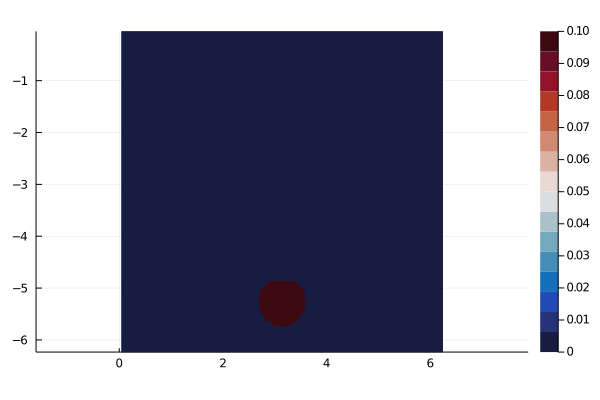

In [6]:
xb, yb, zb = nodes(b)
contourf(xb,zb,b[1:64,1,1:64]',color=:balance, aspect_ratio=:equal)

In [7]:
# Now we construct a simulation that prints out the iteration and model time as it runs.

progress(sim) = @info "Iteration: $(sim.model.clock.iteration), time: $(round(Int, sim.model.clock.time))"

simulation = Simulation(model, Δt=0.2, stop_time=40.0, iteration_interval=20, progress=progress);



In [8]:
# Output
#
# We set up an output writer for the simulation that saves the vorticity every 1 seconds (50 iterations).


using Oceananigans.OutputWriters

simulation.output_writers[:fields] = JLD2OutputWriter(model, (b=b,u=u,w=w),
                                                      schedule = TimeInterval(1.0),
                                                      prefix = "gravity_current",
                                                      force = true);
                  

In [9]:
#  Running the simulation

run!(simulation)

┌ Info: Iteration: 20, time: 4
└ @ Main In[7]:3
┌ Info: Iteration: 40, time: 8
└ @ Main In[7]:3
┌ Info: Iteration: 60, time: 12
└ @ Main In[7]:3
┌ Info: Iteration: 80, time: 16
└ @ Main In[7]:3
┌ Info: Iteration: 100, time: 20
└ @ Main In[7]:3
┌ Info: Iteration: 120, time: 24
└ @ Main In[7]:3
┌ Info: Iteration: 140, time: 28
└ @ Main In[7]:3
┌ Info: Iteration: 160, time: 32
└ @ Main In[7]:3
┌ Info: Iteration: 180, time: 36
└ @ Main In[7]:3
┌ Info: Iteration: 200, time: 40
└ @ Main In[7]:3
┌ Info: Simulation is stopping. Model time 40.000 seconds has hit or exceeded simulation stop time 40 seconds.
└ @ Oceananigans.Simulations /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/Simulations/run.jl:40
